## Импортируем библиотеки

In [1]:
import os
import torch
import time
import pandas as pd
import numpy as np

from torch import nn, optim
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image

from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!nvidia-smi
torch.cuda.is_available()

Fri Mar 14 00:57:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.47                 Driver Version: 572.47         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   38C    P8             13W /   95W |    3961MiB /   6144MiB |     17%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

## Подготовка

In [3]:
CFG = {
    "image_size": 380,
    "batch_size": 32,
    "num_epochs": 5,
    "lr": 3e-4,
    "num_classes": 18,
    "num_categories": 4,  # One-Hot Encoding для 4 категорий
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    'seed': 42
}
# Фиксация seed-ов
np.random.seed(CFG['seed'])
torch.manual_seed(CFG['seed'])
torch.cuda.manual_seed_all(CFG['seed'])
torch.backends.cudnn.deterministic = True

In [4]:
# Подготовка кодировщиков
category_encoder = LabelEncoder()
color_encoder = LabelEncoder()

# Загрузка данных
train_df = pd.read_csv("./dataset_colors/train_data.csv")
train_df["category_encoded"] = category_encoder.fit_transform(train_df["category"])
train_df["target_encoded"] = color_encoder.fit_transform(train_df["target"])

# Разделение на train/val
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df[["target", "category"]], random_state=CFG['seed'])

In [5]:
print("Распределение в трейне:", train_df["target"].value_counts())

Распределение в трейне: target
chernyi         6255
belyi           3324
korichnevyi     2938
raznocvetnyi    2573
bezhevyi        2177
sinii           2045
rozovyi         1687
seryi           1568
zelenyi          928
krasnyi          746
goluboi          666
fioletovyi       424
bordovyi         405
zheltyi          323
oranzhevyi       263
serebristyi      172
zolotoi          119
biryuzovyi        29
Name: count, dtype: int64


## Объявление классов, модели, датасетов, даталоадеров

In [6]:
class ProductDataset(Dataset):
    def __init__(self, df, base_image_path, mode="train"):
        self.df = df
        self.base_image_path = base_image_path
        self.mode = mode
        self.supported_extensions = ['.jpg', '.jpeg', '.png']  
        self.num_categories = 4

        self.image_transform = transforms.Compose([
            transforms.Resize((CFG["image_size"], CFG["image_size"])),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        if self.mode == "train":
            self.image_transform.transforms.insert(0, transforms.RandomHorizontalFlip(p=0.5))
            self.image_transform.transforms.insert(0, transforms.ColorJitter(0.2, 0.2, 0.2))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_id = row['id']
        # Ищем файл с подходящим расширением
        image_path = None
        for ext in self.supported_extensions:
            possible_path = os.path.join(self.base_image_path, f"{image_id}{ext}")
            if os.path.exists(possible_path):
                image_path = possible_path
                break
                
        if image_path is None:
            raise FileNotFoundError(f"No image found for ID {image_id} with extensions {self.supported_extensions}")
        
        image = Image.open(image_path).convert("RGB")
        image = self.image_transform(image)
        
        # One-Hot Encoding категории
        category = row["category_encoded"]
        category_ohe = torch.zeros(self.num_categories)
        category_ohe[category] = 1.0
        
        if self.mode == "train":
            target = torch.tensor(row["target_encoded"], dtype=torch.long)
            return image, category_ohe, target
        
        return image, category_ohe

In [7]:
class ColorClassifier(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg

        self.backbone = models.efficientnet_b4(weights='IMAGENET1K_V1')

        # замораживаем все слои кроме 3х последних
        for param in self.backbone.parameters():
            param.requires_grad = False
        for block in self.backbone.features[-3:]:
            for param in block.parameters():
                param.requires_grad = True

        # Автоматический расчет размера фичей
        dummy = torch.randn(1, 3, cfg["image_size"], cfg["image_size"])
        with torch.no_grad():
            features = self.backbone.features(dummy)
        self.features_size = features.view(1, -1).size(1)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.features_size + cfg["num_categories"], 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, CFG["num_classes"])
        )

    def forward(self, image, category_ohe):
         # Извлекаем признаки изображения через EfficientNet
        features = self.backbone.features(image)
        features = torch.flatten(features, start_dim=1)
        
        # Объединяем с категорией
        combined = torch.cat([features, category_ohe], dim=1)
        return self.classifier(combined)

In [8]:
model = ColorClassifier(CFG).to(CFG["device"])

optimizer = optim.AdamW(model.parameters(), lr=CFG["lr"])
# Веса классов обратно пропорциональны частоте
class_weights = 1. / torch.FloatTensor(train_df["target"].value_counts(normalize=True).sort_index().values)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(CFG["device"]))

In [9]:
generator = torch.Generator()
generator.manual_seed(CFG['seed'])

# DataLoaders
train_dataset = ProductDataset(train_df, "./dataset_colors/train_data", "train")
val_dataset = ProductDataset(val_df, "./dataset_colors/train_data", "train")

train_loader = DataLoader(train_dataset, batch_size=CFG["batch_size"], shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=CFG["batch_size"], generator=generator)

## Обучение

In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for images, categories_ohe, targets in progress_bar:
            images = images.to(device)
            categories_ohe = categories_ohe.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images, categories_ohe)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            progress_bar.set_postfix({'train_loss': f'{loss.item():.4f}'})
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            val_progress = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for images, categories_ohe, targets in val_progress:
                images = images.to(device)
                categories_ohe = categories_ohe.to(device)
                targets = targets.to(device)

                outputs = model(images, categories_ohe)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                
                val_progress.set_postfix({'val_loss': f'{loss.item():.4f}'})

        # Calculate metrics
        train_loss_epoch = train_loss / len(train_loader)
        val_loss_epoch = val_loss / len(val_loader)
        val_acc = accuracy_score(all_targets, all_preds)
        val_f1 = f1_score(all_targets, all_preds, average='macro')
        
        # Update history
        history['train_loss'].append(train_loss_epoch)
        history['val_loss'].append(val_loss_epoch)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        # Print metrics
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f}')
        print(f'Val Accuracy: {val_acc:.4f} | Val F1: {val_f1:.4f}')
        
        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'New best model saved with F1: {best_f1:.4f}')
    
    print('\nTraining complete!')
    return history

In [11]:
#очищаем память видеокарты на всякий случай
torch.cuda.empty_cache()

In [13]:
# Запуск обучения
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=CFG["num_epochs"],
    device=CFG["device"]
)

Epoch 1/5 [Train]:   0%|          | 0/833 [00:00<?, ?it/s]

Epoch 1/5 [Val]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 1/5
Train Loss: 2.4654 | Val Loss: 1.7956
Val Accuracy: 0.5085 | Val F1: 0.3676
New best model saved with F1: 0.3676


Epoch 2/5 [Train]:   0%|          | 0/833 [00:00<?, ?it/s]

Epoch 2/5 [Val]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 2/5
Train Loss: 1.7961 | Val Loss: 1.6284
Val Accuracy: 0.5622 | Val F1: 0.4369
New best model saved with F1: 0.4369


Epoch 3/5 [Train]:   0%|          | 0/833 [00:00<?, ?it/s]

Epoch 3/5 [Val]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 3/5
Train Loss: 1.4611 | Val Loss: 1.6104
Val Accuracy: 0.5730 | Val F1: 0.4564
New best model saved with F1: 0.4564


Epoch 4/5 [Train]:   0%|          | 0/833 [00:00<?, ?it/s]

Epoch 4/5 [Val]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 4/5
Train Loss: 1.2078 | Val Loss: 1.5945
Val Accuracy: 0.5792 | Val F1: 0.4748
New best model saved with F1: 0.4748


Epoch 5/5 [Train]:   0%|          | 0/833 [00:00<?, ?it/s]

Epoch 5/5 [Val]:   0%|          | 0/209 [00:00<?, ?it/s]


Epoch 5/5
Train Loss: 1.0684 | Val Loss: 1.6909
Val Accuracy: 0.6103 | Val F1: 0.4905
New best model saved with F1: 0.4905

Training complete!


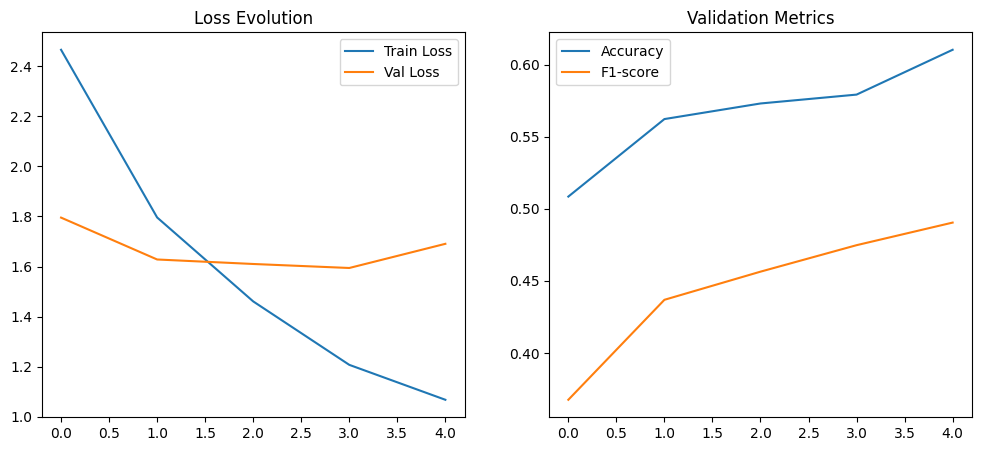

In [14]:
# Визуализация истории обучения (дополнительно)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Accuracy')
plt.plot(history['val_f1'], label='F1-score')
plt.title('Validation Metrics')
plt.legend()

plt.show()

## Загрузка сохраненных весов модели и дальнейшая работа с ними

In [12]:
# Создаем экземпляр модели
model = ColorClassifier(CFG).to(CFG["device"])

# Загружаем веса из файла
model.load_state_dict(torch.load("best_model.pth", map_location=CFG["device"])) 

C:\Users\Alex\AppData\Local\Temp\ipykernel_5080\1031367344.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_locatio

<All keys matched successfully>

### Проверка работы модели

In [13]:
def predict_one_sample(model, image, category_ohe, device=CFG["device"]):
    """Предсказание для одного примера (с учетом категории)"""
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)  # Добавляем batch-размер
        category_ohe = category_ohe.unsqueeze(0).to(device)
        output = model(image, category_ohe)
        probs = torch.nn.functional.softmax(output, dim=1).cpu().numpy()[0]
    return probs

In [14]:
# Выбираем случайный пример из валидационного набора
idx = np.random.randint(0, len(val_dataset))
image, category_ohe, true_label = val_dataset[idx]

# Получаем предсказание
probs = predict_one_sample(model, image, category_ohe)

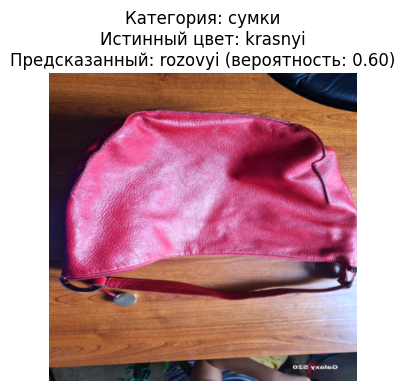

In [15]:
# Выбираем случайный пример из валидационного набора
idx = np.random.randint(0, len(val_dataset))
image, category_ohe, true_label = val_dataset[idx]

# Получаем предсказание
probs = predict_one_sample(model, image, category_ohe)
predicted_label = np.argmax(probs)

# Преобразуем метки
predicted_color = color_encoder.inverse_transform([predicted_label])[0]
true_color = color_encoder.inverse_transform([true_label])[0]
category_name = category_encoder.inverse_transform([torch.argmax(category_ohe).item()])[0]

# Визуализируем
plt.figure(figsize=(8, 4))
inp = image.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.imshow(inp)  # Денормализация
plt.title(f"Категория: {category_name}\nИстинный цвет: {true_color}\nПредсказанный: {predicted_color} (вероятность: {probs[predicted_label]:.2f})")
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


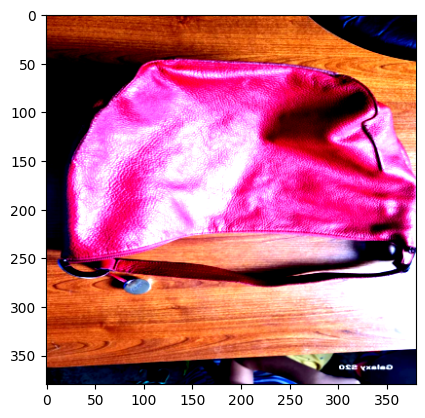

In [16]:
plt.imshow(image.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # Денормализация

In [17]:
def predict_batch(model, batch_images, batch_categories, device=CFG["device"]):
    """Предсказание для батча данных"""
    model.eval()
    with torch.no_grad():
        images = batch_images.to(device)
        categories = batch_categories.to(device)
        outputs = model(images, categories)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probs

# Пример использования
batch_size = 8
indices = np.random.choice(len(val_dataset), batch_size, replace=False)
batch = [val_dataset[i] for i in indices]

images = torch.stack([item[0] for item in batch])
categories = torch.stack([item[1] for item in batch])
true_labels = [item[2] for item in batch]

# Получаем предсказания
probs = predict_batch(model, images, categories)
predicted_labels = np.argmax(probs, axis=1)

# Вычисляем метрики
from sklearn.metrics import f1_score
f1 = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1-score: {f1:.4f}")

F1-score: 0.1625


### Проверка ~9 минут F1 меры, получилось 0.4836, маловато :(

In [ ]:
# # Запуск оценки
# val_loader = DataLoader(val_dataset, batch_size=CFG["batch_size"], shuffle=False)

# model.eval()
# all_preds = []
# all_targets = []
# all_categories = []

# with torch.no_grad():
#     for images, categories_ohe, targets in val_loader:
#         images = images.to(CFG["device"])
#         categories_ohe = categories_ohe.to(CFG["device"])
        
#         outputs = model(images, categories_ohe)
#         _, preds = torch.max(outputs, 1)
        
#         all_preds.extend(preds.cpu().numpy())
#         all_targets.extend(targets.cpu().numpy())
        
#         # Преобразуем OHE категории обратно в числовые метки
#         category_labels = torch.argmax(categories_ohe, dim=1).cpu().numpy()
#         all_categories.extend(category_labels)

# # Общая метрика
# total_f1 = f1_score(all_targets, all_preds, average='macro')
# print(f"Overall F1-score (macro): {total_f1:.4f}\n")

# # Метрики по категориям
# df = pd.DataFrame({
#     'true': all_targets,
#     'pred': all_preds,
#     'category': all_categories
# })

# # Преобразуем числовые метки в названия
# df['category_name'] = df['category'].map(
#     dict(enumerate(category_encoder.classes_))
# )

Overall F1-score (macro): 0.4836



In [ ]:
# # Выводим отчет по каждой категории
# for category in df['category_name'].unique():
#     subset = df[df['category_name'] == category]
#     f1 = f1_score(subset['true'], subset['pred'], average='macro')
#     print(f"Category: {category}")
#     print(f"Samples: {len(subset)}")
#     print(f"F1-score (macro): {f1:.4f}\n")
#     print(classification_report(
#         subset['true'], 
#         subset['pred'], 
#         labels=np.arange(len(color_encoder.classes_)),  # Явно указываем все классы
#         target_names=color_encoder.classes_,
#         zero_division=0
#     ))
#     print("--------------------------------------------------")

# print(total_f1)

Category: столы
Samples: 760
F1-score (macro): 0.1958

              precision    recall  f1-score   support

       belyi       0.82      0.73      0.78       200
    bezhevyi       0.53      0.62      0.57       167
  biryuzovyi       0.00      0.00      0.00         2
    bordovyi       0.00      0.00      0.00         2
     chernyi       0.48      0.21      0.29        53
  fioletovyi       0.00      0.00      0.00         0
     goluboi       0.00      0.00      0.00         3
 korichnevyi       0.71      0.75      0.73       248
     krasnyi       0.00      0.00      0.00         2
  oranzhevyi       0.00      0.00      0.00         5
raznocvetnyi       0.00      0.00      0.00        15
     rozovyi       0.00      0.00      0.00         2
 serebristyi       0.10      0.50      0.17         4
       seryi       0.24      0.25      0.25        36
       sinii       0.33      0.50      0.40         2
     zelenyi       0.00      0.00      0.00         4
     zheltyi       1.00   

### Замер времени предсказания одной картинки

In [ ]:
# Выбираем случайный пример из валидационного набора
idx = np.random.randint(0, len(val_dataset))
time_test_image, time_test_category_ohe, time_test_true_label = val_dataset[idx]

def measure_inference_time(model, image, category_ohe, n_runs=100):
    # Прогрев (warm-up)
    image = image.unsqueeze(0).to(CFG['device'])  # Добавляем batch-размер
    category_ohe = category_ohe.unsqueeze(0).to(CFG['device'])
    model.eval()
    with torch.no_grad():
        for _ in range(10):
            _ = model(image, category_ohe)
    
    # Замер времени
    start_time = time.perf_counter()
    with torch.no_grad():
        for _ in range(n_runs):
            _ = model(image, category_ohe)
    total_time = time.perf_counter() - start_time
    
    return (total_time / n_runs) * 1000  # Время в мс на один запрос


avg_time = measure_inference_time(model, time_test_image, time_test_category_ohe)
print(f"Среднее время предсказания: {avg_time:.2f} мс")


Среднее время предсказания: 20.11 мс


In [98]:
avg_time = measure_inference_time(model, time_test_image, time_test_category_ohe, 1)
print(f"Среднее время предсказания: {avg_time:.2f} мс")

Среднее время предсказания: 29.86 мс


## создание Submit файла

In [130]:
test_df = pd.read_csv("./dataset_colors/test_data.csv")
test_df["category_encoded"] = category_encoder.transform(test_df["category"])

# Создаем Dataset для тестовых данных
test_dataset = ProductDataset(test_df, "./dataset_colors/test_data", mode="test")

# Предсказания для всех тестовых данных
all_preds = []
all_probs = []

In [131]:
model.eval()
with torch.no_grad():
    for image, category_ohe in tqdm(DataLoader(test_dataset, batch_size=32)):
        image = image.to(CFG["device"])
        category_ohe = category_ohe.to(CFG["device"])
        outputs = model(image, category_ohe)
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
        all_probs.extend(probs)
        all_preds.extend(np.argmax(probs, axis=1))

  0%|          | 0/45 [00:00<?, ?it/s]

In [158]:
# Форматируем выходные данные
submission = []
for i, (prob, pred_idx) in enumerate(zip(all_probs, all_preds)):
    row = {
        "id": test_df.iloc[i]["id"],
        "category": test_df.iloc[i]["category"],
        "predict_proba": {color: round(float(prob), 4) for color, prob in zip(color_encoder.classes_, prob)},
        "predict_color": color_encoder.classes_[pred_idx]
    }
    submission.append(row)

# Сохраняем в CSV
pd.DataFrame(submission).to_csv("submission.csv", index=False)

In [154]:
submit_df = pd.DataFrame(submission)
submit_df.head()

,id,category,predict_proba,predict_color
0,36490520922,столы,"{'belyi': 0.0009, 'bezhevyi': 0.0012, 'biryuzo...",krasnyi
1,37619737558,столы,"{'belyi': 0.9964, 'bezhevyi': 0.0035, 'biryuzo...",belyi
2,37601169296,столы,"{'belyi': 0.0, 'bezhevyi': 0.0032, 'biryuzovyi...",korichnevyi
3,26991200895,сумки,"{'belyi': 0.2217, 'bezhevyi': 0.5956, 'biryuzo...",bezhevyi
4,27005406560,сумки,"{'belyi': 0.0691, 'bezhevyi': 0.449, 'biryuzov...",bezhevyi


In [157]:
sorted(submit_df['predict_proba'][0].items(), key=lambda item: item[1], reverse=True)

[('krasnyi', 0.4993),
 ('rozovyi', 0.342),
 ('raznocvetnyi', 0.1417),
 ('oranzhevyi', 0.0114),
 ('goluboi', 0.0018),
 ('bezhevyi', 0.0012),
 ('belyi', 0.0009),
 ('zelenyi', 0.0009),
 ('bordovyi', 0.0005),
 ('seryi', 0.0002),
 ('chernyi', 0.0001),
 ('fioletovyi', 0.0001),
 ('korichnevyi', 0.0001),
 ('sinii', 0.0001),
 ('biryuzovyi', 0.0),
 ('serebristyi', 0.0),
 ('zheltyi', 0.0),
 ('zolotoi', 0.0)]